In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [7]:
# Load the VGG16 model pre-trained on ImageNet
vgg16 = models.vgg16(pretrained=True)

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Freeze the parameters of the base model
for param in vgg16.parameters():
    param.requires_grad = False

In [8]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
vgg16.classifier #It has 6 layers in classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [6]:
num_classes = 10  # Assuming 15 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

In [2]:
# Load data
from sklearn.model_selection import train_test_split
from PIL import Image


data_dir = '../archive/fashion-mnist_test.csv'

df = pd.read_csv(data_dir)

train, test = train_test_split(df, test_size=0.2)
print(train.shape, test.shape)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize from 28x28 to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel to 3 channels
    transforms.ToTensor(),  # Convert to tensor (Shape: 3x224x224)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])

class Images(Dataset):
    def __init__(self, df, transform=None):
       self.data = df
       self.transform = transform
        

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_arr = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28, 1)
        image_arr = image_arr.reshape(28, 28)
        image = Image.fromarray(image_arr).convert('L')
        if self.transform:
            image = self.transform(image)

        label = self.data.iloc[idx, 0]
        return image, label
    
dataset = Images(train, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

image, label = dataset[0]
print(image.shape, label)


(8000, 785) (2000, 785)
torch.Size([3, 224, 224]) 5


In [11]:
epoch = 10
loss_epoch = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'device = {device}')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

vgg16 = vgg16.to(device)

for e in range(epoch):
    vgg16.train()
    for inputs, label in train_loader:
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = vgg16(inputs)
        loss = criterion(output, label)
        # loss_epoch.append(loss)
        loss.backward()
        optimizer.step()
    print(f'Epoch {e} Loss = {loss.item()}')


device = mps
Epoch 0 Loss = 0.6167213320732117
Epoch 1 Loss = 0.4647424519062042
Epoch 2 Loss = 0.7905441522598267
Epoch 3 Loss = 0.3539911210536957
Epoch 4 Loss = 0.4115242660045624
Epoch 5 Loss = 0.4120909571647644
Epoch 6 Loss = 0.3159768581390381
Epoch 7 Loss = 0.3821731209754944
Epoch 8 Loss = 0.4641561508178711
Epoch 9 Loss = 0.22417005896568298


In [13]:
torch.save(vgg16.state_dict(), 'model_weight.pth')

In [3]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Resize to 224x224
    transforms.Lambda(lambda x: x.expand(3, -1, -1))  # Convert grayscale (1 channel) to RGB (3 channels)
])

X_test = test.iloc[:, 1:].values.astype(np.uint8).reshape(-1, 28, 28, 1)
X_test = X_test[:1000,:]/255.0
X_test = tensor_data = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28)

Y_test = test.iloc[:, 0].values
X_test = torch.stack([data_transform(img) for img in X_test])
Y_test = torch.tensor(Y_test[:1000], dtype=torch.long)
X_test.shape, Y_test.shape

(torch.Size([1000, 3, 224, 224]), torch.Size([1000]))

In [4]:

vgg16 = models.vgg16()
vgg16.classifier[6] = torch.nn.Linear(4096, 10)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
print(f'device = {device}')

vgg16.load_state_dict(torch.load("model_weight.pth", map_location=device))
vgg16 = vgg16.to(device)
vgg16.eval()
# vgg16


X_test = X_test.to(device)
Y_test = Y_test.to(device)
# vgg16_cpu = vgg16.to('cpu')
with torch.no_grad():
    output = vgg16(X_test)
output


device = cpu


tensor([[ 1.4848,  0.6204, -0.8334,  ..., -7.2823, -1.9788, -4.1186],
        [-0.8841, -3.3324, -3.0476,  ..., -1.2458,  1.8186,  0.1982],
        [-2.0092, -3.9275, -3.5999,  ...,  1.1512,  0.6051,  1.1109],
        ...,
        [-1.3349, -0.7823,  3.0405,  ..., -9.1458, -5.1565, -8.0074],
        [-1.9401, -5.8469, -2.8515,  ...,  2.2186,  0.9892, -0.5701],
        [ 0.6312, -6.3558,  0.8244,  ..., -8.7162,  5.1179, -4.8110]])

Accuracy: 0.605
Precision: 0.7342281276775325
Recall: 0.6072630714749905
F1: 0.5644224763060713


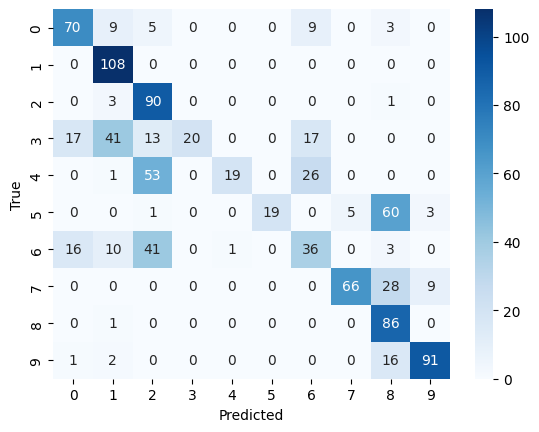

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import heatmap


_, predicted = torch.max(output, 1)
accuracy = accuracy_score(Y_test, predicted)
precision = precision_score(Y_test, predicted, average='macro')
recall = recall_score(Y_test, predicted, average='macro')
f1 = f1_score(Y_test, predicted, average='macro')
cm = confusion_matrix(Y_test, predicted)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()